In [836]:
import tensorflow as tf
import numpy as np
import cv2
import base64
import io
import json
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten
from tensorflow.keras.layers import Dense, Reshape, Input, BatchNormalization
from tensorflow.data import Dataset
from PIL import Image
from keras.models import load_model
from prepare_img import preprocessing_fun

from plt_fn import show_images

IMAGE_SHAPE = (70,70)
batch_size = 64
tf.random.set_seed(10)
l2_lambda = 0.0001 

In [837]:
img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    preprocessing_function = preprocessing_fun,
    validation_split=0.25
)

In [838]:
training_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="training"
)
validation_gen = img_datagen.flow_from_directory(
    'TRAIN',
    target_size=IMAGE_SHAPE,
    color_mode='grayscale',
    batch_size=batch_size,
    shuffle=True,
    seed=10,
    subset="validation"
)

Found 12022 images belonging to 33 classes.
Found 3992 images belonging to 33 classes.


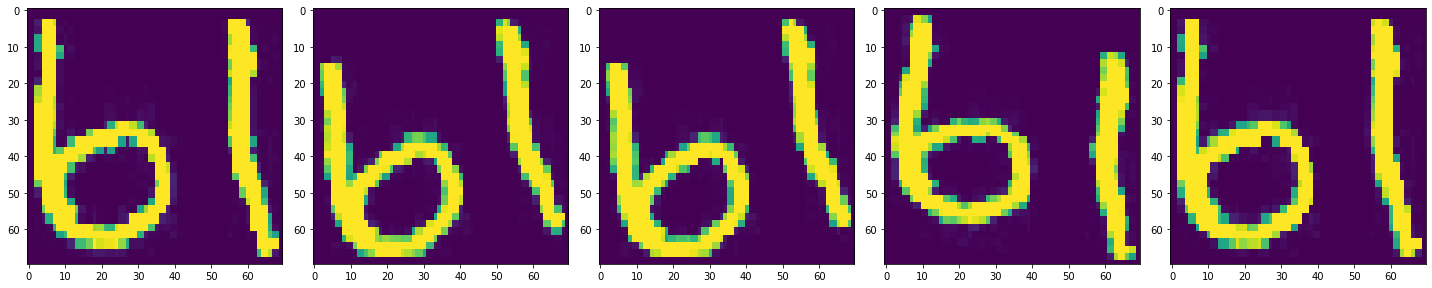

In [839]:
augmented_images = [training_gen[0][0][0] for i in range(5)]

fig, axes = plt.subplots(1, 5, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip( augmented_images, axes):
        ax.imshow(img.astype('uint8'))
plt.tight_layout()
plt.show()

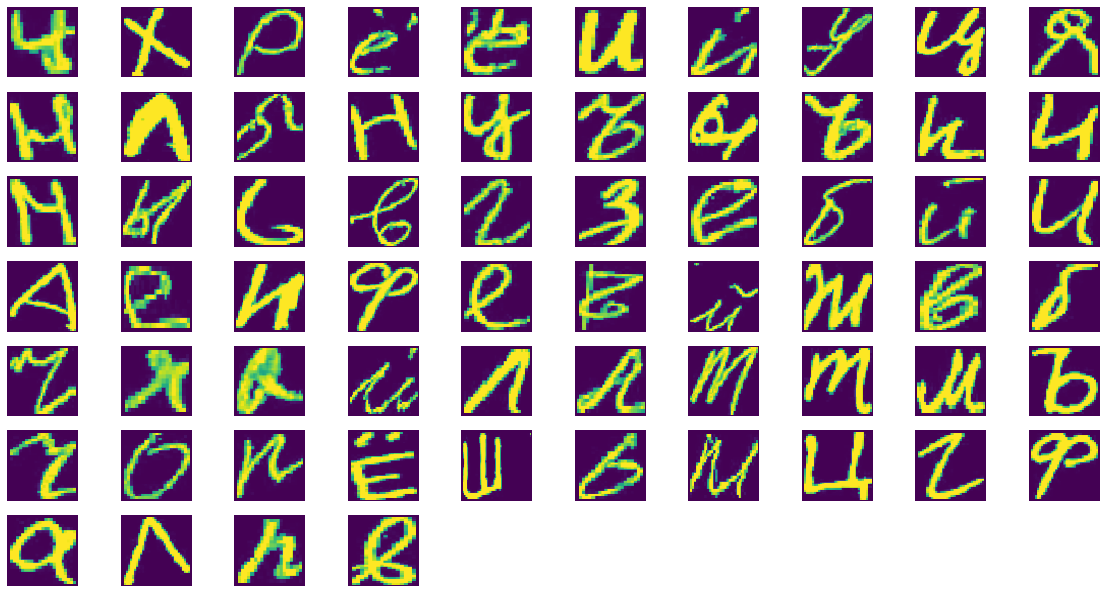

In [805]:
plt.figure(figsize=(20, 20))
def show_images(train_ds, class_names, n = 9):
    images, labels = train_ds[2]
    for i in range(64):
        ax = plt.subplot(13, 10, i + 1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis("off")
show_images(training_gen, np.array(set(training_gen.labels)))

In [812]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(*IMAGE_SHAPE, 1))
]

In [813]:
def conv_2d_pooling_layers(filters, drop_prob):
    return [
        tf.keras.layers.Conv2D(
            filters,
            (4,4),
            activation='relu',
            padding='same',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(drop_prob),
    ]

core_layers = \
    conv_2d_pooling_layers(32, 0.25) + \
    conv_2d_pooling_layers(64, 0.25) + \
    conv_2d_pooling_layers(128, 0.5)

In [814]:
dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, kernel_initializer='he_uniform', 
                          activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)),
    tf.keras.layers.BatchNormalization(axis=1),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(33, kernel_initializer='glorot_uniform', activation='softmax')
]

In [815]:
model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_16 (Rescaling)    (None, 70, 70, 1)         0         
                                                                 
 conv2d_50 (Conv2D)          (None, 70, 70, 32)        544       
                                                                 
 max_pooling2d_50 (MaxPoolin  (None, 35, 35, 32)       0         
 g2D)                                                            
                                                                 
 dropout_63 (Dropout)        (None, 35, 35, 32)        0         
                                                                 
 conv2d_51 (Conv2D)          (None, 35, 35, 64)        32832     
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 17, 17, 64)       0         
 g2D)                                                

In [816]:
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [817]:
history = model.fit(
    training_gen,
    steps_per_epoch=int(np.ceil(training_gen.n / float(batch_size))),
    validation_data = validation_gen,
    validation_steps=int(np.ceil(validation_gen.n / float(batch_size))),
    epochs = 50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
188/188 [==============================] - 49s 259ms/step - loss: 1.9452 - accuracy: 0.5037 - val_loss: 1.7781 - val_accuracy: 0.7227
Epoch 2/50
188/188 [==============================] - 52s 277ms/step - loss: 1.0584 - accuracy: 0.7410 - val_loss: 0.9098 - val_accuracy: 0.8006
Epoch 3/50
188/188 [==============================] - 51s 271ms/step - loss: 0.8662 - accuracy: 0.7896 - val_loss: 0.8405 - val_accuracy: 0.8064
Epoch 4/50
188/188 [==============================] - 51s 272ms/step - loss: 0.7661 - accuracy: 0.8257 - val_loss: 0.8590 - val_accuracy: 0.7986
Epoch 5/50
188/188 [==============================] - 52s 275ms/step - loss: 0.7224 - accuracy: 0.8356 - val_loss: 0.6749 - val_accuracy: 0.8522
Epoch 6/50
188/188 [==============================] - 46s 247ms/step - loss: 0.6811 - accuracy: 0.8520 - val_loss: 0.6255 - val_accuracy: 0.8720
Epoch 7/50
188/188 [==============================] - 48s 257ms/step - loss: 0.6506 - accuracy: 0.8658 - val_loss: 0.6113 - val_ac

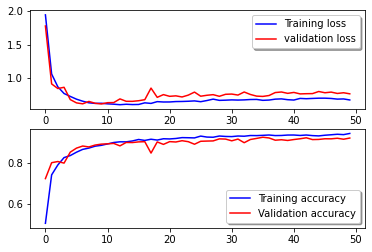

In [819]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [835]:
model.save('weight/20-epoch')

INFO:tensorflow:Assets written to: weight/20-epoch/assets
